In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from torchvision import transforms
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pytesseract import image_to_string

In [2]:
# from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# from PIL import Image
# from IPython.display import display
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten") 
# trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

In [3]:
cropped_images = torch.load('/kaggle/input/iam-forms-cropped-images/cropped_images.pt')

In [4]:
def load_image_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def preprocess(img, w_max, gamma):
    h, w, c = img.shape
    wf, hf = w_max, 1 if int(h*w_max/w) == 0 else int(h*w_max/w)
    img = cv2.resize(img, (wf, hf), interpolation = cv2.INTER_AREA)
    img = 255*(img/255.)**gamma
    img = img.astype(np.uint8)
    return img, (w, h), (wf, hf)

In [5]:
def load_image(image_path, w_max, gamma, hardcoded_range):
    img = load_image_from_path(image_path)
    hd1, hd2 = hardcoded_range
    hardcoded_img = img[hd1: hd2]
    img, (w, h), (wf, hf) = preprocess(img, w_max, gamma)
    hardcoded_img, (_, _), (_, _) = preprocess(hardcoded_img, w_max, gamma)
    wr, hr = wf/w, hf/h
    return img, hardcoded_img, (wf, hf), (wr, hr)

def thresholding(image, threshold):
    # grayscaling the image
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # all pixels below threshold will turn black and rest will become 255
    _, thresh_img = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh_img


def dilate(thresh_img, kernel_dims):
    kernel = np.ones(kernel_dims, np.uint8)
    dilated_img = cv2.dilate(thresh_img, kernel, iterations = 1)
    return dilated_img


In [6]:
def generate_para(img, threshold, kernel_dims):
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    para_list = []
    para_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        para_list.append([x, y, w, h])
        para_images.append(img[y:y+h, x:x+w])
        break
        
    return para_images[0], para_list[0]

In [7]:
def get_img_and_vars(image_path, w_max, gamma, hardcoded_range, threshold, kernel_dims):
    img, himg, (wf, hf), (wr, hr) = load_image(image_path, w_max, gamma, hardcoded_range)
    para_img, (x,y,w,h) = generate_para(himg, threshold, kernel_dims)
    y = y + HARDCODED_RANGE[0]*hr
    y = int(y)
    return img, (x,y,w,h), (x/wf, y/hf, w/wf, h/hf)

In [8]:
image_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])

def return_tensor(image):
    image = fromarray(image)
    return image_transform(image)

---

In [9]:
GAMMA = 2
W_MAX = 1000
THRESHOLD = 40
KERNEL_DIMS = (85,85)
HARDCODED_RANGE = (710,2800)

In [10]:
# def ocr_image(img):
#     pixel_values = processor(images=img, return_tensors="pt").pixel_values
#     generated_ids = trocr_model.generate(pixel_values)
#     return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [11]:
tensor_to_img_transform = transforms.ToPILImage()

def line_to_text(line_img_tensor):
    line_img = tensor_to_img_transform(line_img_tensor)
    text = image_to_string(line_img)
    return text

In [12]:
def tensor_to_cvarray(img_tensor):
    img = tensor_to_img_transform(img_tensor)
    cv_img = np.array(img)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
    return cv_img

In [13]:
def convert_to_tensor(image, w, h):
    image = fromarray(image)
    image = transforms.Compose([transforms.Resize((h,w)), transforms.Grayscale(), transforms.ToTensor()])(image)
    return image

In [14]:
# char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "

# def encode_to_labels(text, max_word_length=150):
#     dig_list = []
#     for index in range(max_word_length):
#         char = 79
#         if index < len(text):
#             char = char_list.index(text[index])
#         dig_list.append(char) 
#     return dig_list

# def get_text(sequence):
#     text = ""
#     for i in sequence:
#         if i != 79:
#             text += char_list[i]
#     return text

In [15]:
def generate_lines_for_mask(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    img = tensor_to_cvarray(img_tensor)
    img, _, _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    lines_images = []

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            lines_images.append(img[y:y+h, x:x+w])
            
    if len(lines_images) <= num_lines_threshold:
        lines_images = []
    
    lines_tensor_list = []
    lines_text_list = []
    for each in lines_images:
        lines_tensor_list.append(convert_to_tensor(each, 900, 30))
#         lines_text_list.append(
#             encode_to_labels(ocr_image(each))
#         )
    
#     return lines_tensor_list, lines_text_list
    return lines_tensor_list

In [34]:
def generate_mask(img_tensor, w_max, gamma, threshold, kernel_dims, num_lines_threshold=4):
    num_lines = 0
    img = tensor_to_cvarray(img_tensor)
    img, (W,H), _ = preprocess(img, w_max, gamma)
    thresh_img = thresholding(img, threshold)
    dilated_img = dilate(thresh_img, kernel_dims)

    (contours, heirarchy) = cv2.findContours(dilated_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    
    mask = np.zeros(img.shape, np.uint8)

    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        area = cv2.contourArea(ctr)
        aspect_ratio = float(w) / h
        if w >= 100 and h >= 20 and area>=10000:
            mask[y:y+h, x:x+w] = 255
            num_lines += 1
            
    return convert_to_tensor(img, 885, 903), convert_to_tensor(mask, 885, 903), (num_lines > num_lines_threshold)

In [35]:
def plot_tensor(img, axis='off'):
    plt.imshow(img.permute(1,2,0), cmap='gray')
    if axis == 'off':
        plt.axis('off')
    plt.show()

In [36]:
LINE_KERNEL_DIMS = (20,800)

torch.Size([1, 903, 885])
torch.Size([1, 903, 885])


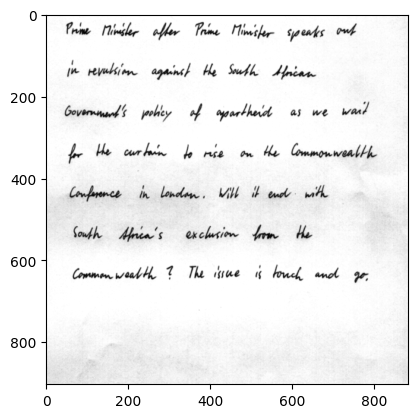

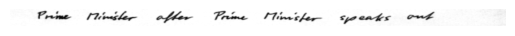

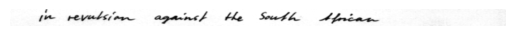

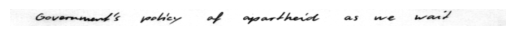

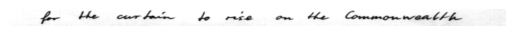

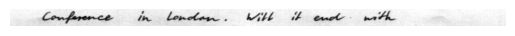

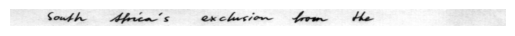

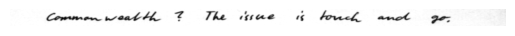

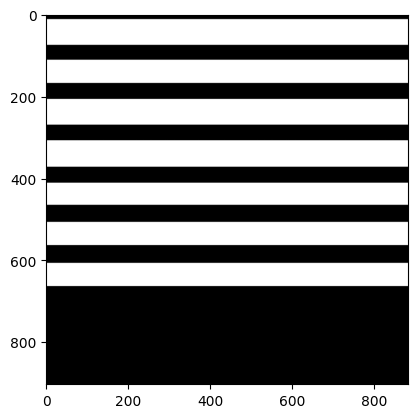

In [37]:
idx = 69
ll = generate_lines_for_mask(cropped_images[idx], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
im, ma, boolean = generate_mask(cropped_images[idx], W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
print(im.shape)
print(ma.shape)
plot_tensor(im, axis='on')
for each in ll:
    plot_tensor(each, axis='off')
plot_tensor(ma, axis='on')
plt.show()

In [38]:
class MaskDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return (self.images[idx], self.masks[idx])

In [41]:
images_list = []
masks_list = []

for each in cropped_images:
    image, mask, boolean = generate_mask(each, W_MAX, GAMMA, THRESHOLD, LINE_KERNEL_DIMS)
    if boolean:
        images_list.append(image)
        masks_list.append(mask)

In [42]:
print(images_list[0].shape)
print(masks_list[0].shape)

torch.Size([1, 903, 885])
torch.Size([1, 903, 885])


In [43]:
md = MaskDataset(images_list, masks_list)

torch.Size([32, 1, 903, 885]) torch.Size([32, 1, 903, 885])


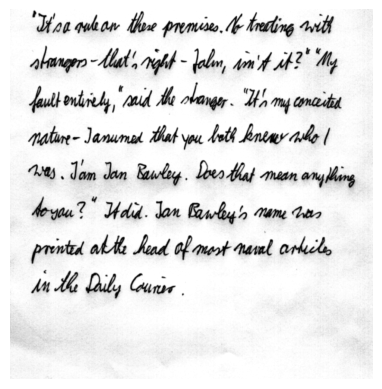

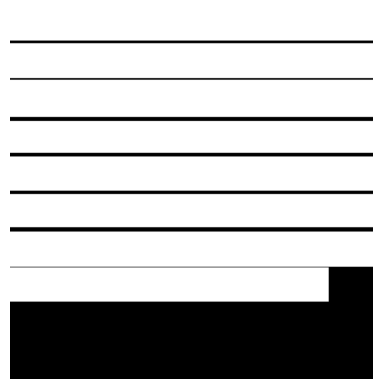

In [51]:
dl = DataLoader(md, batch_size=32, shuffle=True)
for im, ma in dl:
    print(im.shape, ma.shape)
    plot_tensor(im[0])
    plot_tensor(ma[0])
    break

In [46]:
torch.save(md, 'mask_dataset.pt')

In [47]:
from IPython.display import FileLink
%cd /kaggle/working
FileLink(r'mask_dataset.pt')

/kaggle/working


/kaggle/working/mask_dataset.pt

In [ ]:
# class LinesDataset(Dataset):
#     def __init__(self, lines_images, lines_labels):
#         self.lines_images = np.array(lines_images)
#         self.lines_labels = np.array(lines_labels)
        
#     def __len__(self):
#         return len(self.lines_images)
    
#     def __getitem__(self, idx):
#         return (self.lines_images[idx], self.lines_labels[idx])

In [ ]:
# testingd = torch.load('dataset_320_447.pt')
# testloader = DataLoader(testingd, batch_size=32, shuffle=True)

In [ ]:
# for each in testloader:
#     print(each[0].shape, each[1].shape)
#     plot_tensor(each[0][0])
#     print(get_text(each[1][0]))
#     break